##### Library Imports

In [1]:
import numpy as np
import pandas as pd
import cv2
from pascal import PascalVOC
import os
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline
import tensorflow as tf
from tensorflow import keras

##### Read the annotation data and build a pandas dataframe with the filenames and filepaths of annotations and images.

In [2]:
annotation_filenames = []
annotation_filepaths = []
image_filenames = []
image_filepaths = []

dog_image_folder = "generative-dog-images/all-dogs/all-dogs"
for root, dirs, files in os.walk("generative-dog-images/Annotation/Annotation"):
    if len(dirs) == 0:
        for filename in files:
            annotation_filenames.append(filename)
            annotation_filepaths.append(root.replace("\\","/")+"/"+filename)
            image_filenames.append(filename+".jpg")
            image_filepaths.append(dog_image_folder + "/" + filename+".jpg")

paths_df = pd.DataFrame({
    "annotation_filename": annotation_filenames,
    "annotation_filepath": annotation_filepaths,
    "image_filename": image_filenames,
    "image_filepath": image_filepaths
    
})

In [3]:
display(paths_df.head())

,annotation_filename,annotation_filepath,image_filename,image_filepath
0,n02085620_10074,generative-dog-images/Annotation/Annotation/n0...,n02085620_10074.jpg,generative-dog-images/all-dogs/all-dogs/n02085...
1,n02085620_10131,generative-dog-images/Annotation/Annotation/n0...,n02085620_10131.jpg,generative-dog-images/all-dogs/all-dogs/n02085...
2,n02085620_10621,generative-dog-images/Annotation/Annotation/n0...,n02085620_10621.jpg,generative-dog-images/all-dogs/all-dogs/n02085...
3,n02085620_1073,generative-dog-images/Annotation/Annotation/n0...,n02085620_1073.jpg,generative-dog-images/all-dogs/all-dogs/n02085...
4,n02085620_10976,generative-dog-images/Annotation/Annotation/n0...,n02085620_10976.jpg,generative-dog-images/all-dogs/all-dogs/n02085...


##### Helper function to pull the bounding box data from the annotations.

In [4]:
def get_bounding_box_from_ann(path):
    ann = PascalVOC.from_xml(path)
    obj = ann.objects[0]
    bb = obj.bndbox
    xmin = bb.xmin
    xmax = bb.xmax
    ymin = bb.ymin
    ymax = bb.ymax
    return (xmin, ymin, xmax, ymax)    

In [5]:
#Add the bounding boxes to the paths dataframe
paths_df["bounding_box"] = paths_df["annotation_filepath"].apply(lambda x: get_bounding_box_from_ann(x))
#Split the bounding box values into separate columns
paths_df[["xmin", "ymin", "xmax", "ymax"]] = pd.DataFrame(paths_df["bounding_box"].tolist(), index = paths_df.index)

In [6]:
#There's one annotation that exists for a file that wasn't included in the dataset for some reason.
paths_df.drop(index = 13680, inplace=True) #Drop it
paths_df.reindex(axis = "rows") #Reindex
paths_df.head(5)

,annotation_filename,annotation_filepath,image_filename,image_filepath,bounding_box,xmin,ymin,xmax,ymax
0,n02085620_10074,generative-dog-images/Annotation/Annotation/n0...,n02085620_10074.jpg,generative-dog-images/all-dogs/all-dogs/n02085...,"(25, 10, 276, 498)",25,10,276,498
1,n02085620_10131,generative-dog-images/Annotation/Annotation/n0...,n02085620_10131.jpg,generative-dog-images/all-dogs/all-dogs/n02085...,"(49, 9, 393, 493)",49,9,393,493
2,n02085620_10621,generative-dog-images/Annotation/Annotation/n0...,n02085620_10621.jpg,generative-dog-images/all-dogs/all-dogs/n02085...,"(142, 43, 335, 250)",142,43,335,250
3,n02085620_1073,generative-dog-images/Annotation/Annotation/n0...,n02085620_1073.jpg,generative-dog-images/all-dogs/all-dogs/n02085...,"(0, 27, 312, 498)",0,27,312,498
4,n02085620_10976,generative-dog-images/Annotation/Annotation/n0...,n02085620_10976.jpg,generative-dog-images/all-dogs/all-dogs/n02085...,"(90, 104, 242, 452)",90,104,242,452


##### The images, need to be 64x64 pixel, RGB data.

In [7]:
img_shape = (64,64,3)

##### Function to take a row number from a table and pull an image, resize, and output using the OpenCV library.

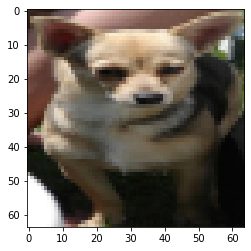

In [8]:
def img_from_row(df, rownum, resize_dim=(img_shape[0],img_shape[1]), show=False):
    i = rownum
    img_path = df["image_filepath"].iloc[i]
    img_bb = df["bounding_box"].iloc[i]
    img = cv2.imread(img_path)
    cc_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cropped_img = cc_img[img_bb[1]:img_bb[3], img_bb[0]:img_bb[2]]
    resized_img = cv2.resize(cropped_img, resize_dim, interpolation = cv2.INTER_AREA)
    if show:
        plt.imshow(resized_img)
    return resized_img
    
cropped = img_from_row(paths_df, 0)
plt.imshow(cropped)

##### Split the paths data into train/test (80/20).

In [9]:
train_paths_df, test_paths_df = train_test_split(paths_df, test_size = 0.2, random_state = 0)
print(train_paths_df.shape)
print(test_paths_df.shape)

(16463, 9)
(4116, 9)


##### Create numpy arrays to hold the images..

In [10]:
def path_df_to_np_img_array(df, img_shape):
    num_img = df.shape[0]
    arr = np.zeros((num_img, img_shape[0], img_shape[1], img_shape[2]))
    for i in range(num_img):
        img = img_from_row(df, i, resize_dim=(img_shape[0],img_shape[1]), show=False)
        img = img/255.0 #Rescale from 0 to 1.
#         img = 2*(img - 0.5) #Rescale from -1 to 1
        arr[i] = img
    return arr    

In [11]:
train_array = path_df_to_np_img_array(train_paths_df, img_shape)
test_array = path_df_to_np_img_array(test_paths_df, img_shape)
print(train_array.shape)
print(test_array.shape)

(16463, 64, 64, 3)
(4116, 64, 64, 3)


##### Check/view sample of training images. They'll look distorted because the data is rescaled to include negative numbers that are truncated in the preview.

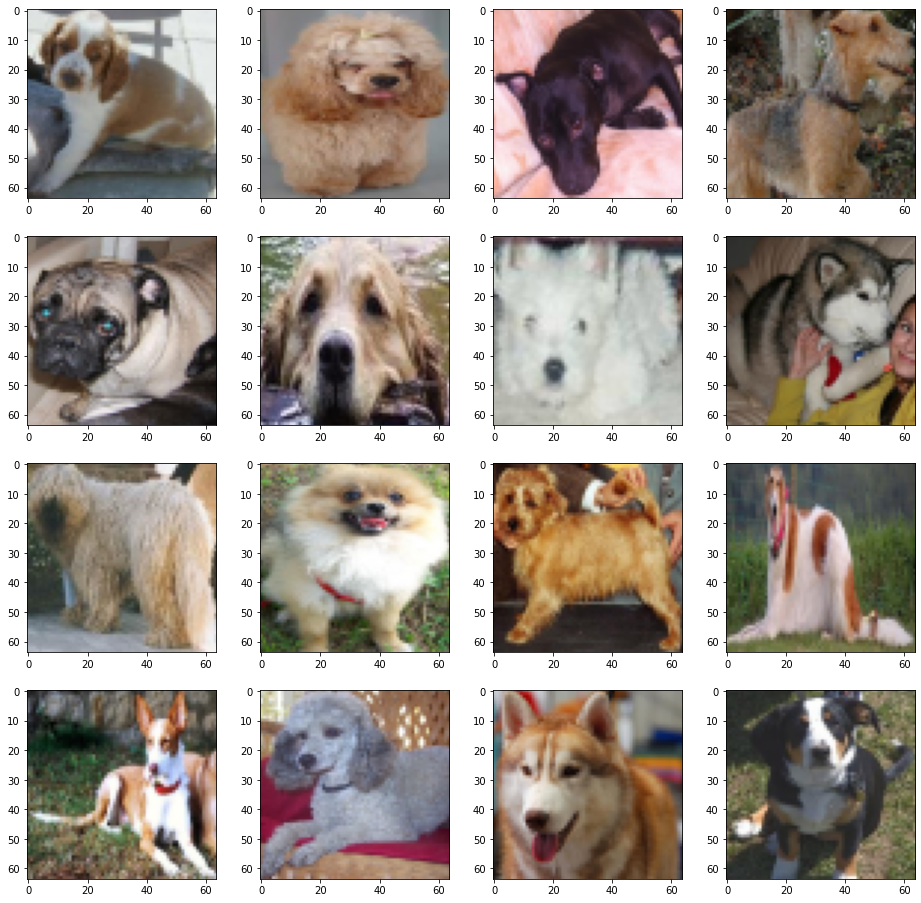

In [12]:
nrows, ncols = 4,4
fig, axs = plt.subplots(nrows, ncols, figsize = (16,16))
for i in range(nrows):
    for j in range(ncols):
        axs[i,j].imshow(train_array[(i*nrows)+j])

##### Check/view sample of testing images.

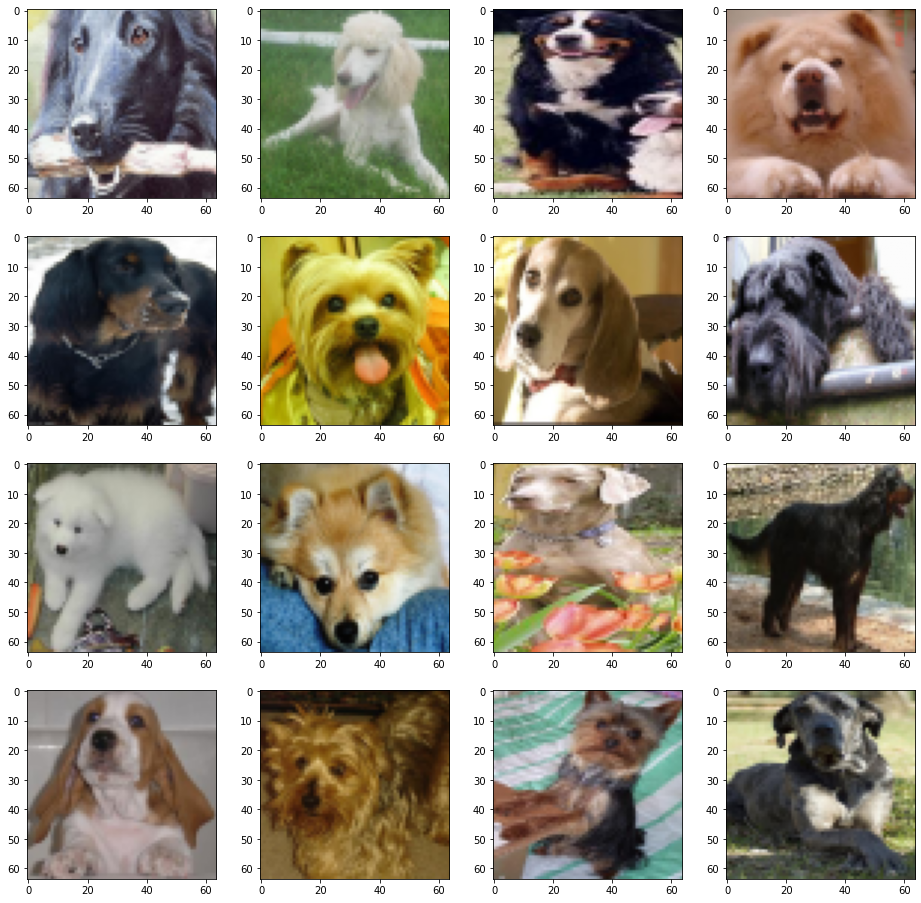

In [13]:
nrows, ncols = 4,4
fig, axs = plt.subplots(nrows, ncols, figsize = (16,16))
for i in range(nrows):
    for j in range(ncols):
        axs[i,j].imshow(test_array[(i*nrows)+j])

#### I found a very straight-forward example for the basic approach to training a deep convolutional generative adversarial network with TensorFlow and Keras, but it requires extensive modification because it's developed around the Fashion MNIST dataset which is 28x28 pixel single-channel images and we've got 64x64 three-channel images. The initial model (with anticipated poor performance) is closely based on the example to assess the general technique and ensure the output is formatted correctly, but additional, more complex models are tested afterward.
<i>Citation: https://www.geeksforgeeks.org/deep-convolutional-gan-with-keras/ </i>

In [14]:
batch_size = 1024
def gen_batch(train_array, batch_size = 16, seed_val = 0):
    data = tf.data.Dataset.from_tensor_slices(train_array).shuffle(seed = seed_val, buffer_size = min(batch_size*100, train_array.shape[0]))
    data = data.batch(batch_size, drop_remainder = True).prefetch(1)
    return data

In [15]:
num_features = 100

generator1 = keras.models.Sequential([
    keras.layers.Dense(8 * 8 * 128, input_shape =[num_features]),
    keras.layers.Reshape([8, 8, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64,(5,5),(4,4),padding="same",activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(img_shape[2],(5,5),(2,2),padding="same",activation="tanh")
], name = "generator1")
generator1.summary()

Model: "generator1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              827392    
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 128)        512       
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 64)       204864    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                        

In [16]:
discriminator1 = keras.models.Sequential([
    keras.layers.Conv2D(64,(5, 5),(2, 2),padding="same",input_shape=img_shape),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128,(5, 5),(2, 2),padding ="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation ='sigmoid')
], name = "discriminator1")
discriminator1.summary()

Model: "discriminator1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 flatten (Flatten)           (None, 32768)          

In [17]:
discriminator1.compile(loss = "binary_crossentropy", optimizer = "adam")
discriminator1.trainable = False
GAN1 = keras.models.Sequential([generator1, discriminator1],name = "GAN1")
GAN1.compile(loss = "binary_crossentropy", optimizer = "adam")
GAN1.summary()

Model: "GAN1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator1 (Sequential)     (None, 64, 64, 3)         1037827   
                                                                 
 discriminator1 (Sequential)  (None, 1)                242561    
                                                                 
Total params: 1,280,388
Trainable params: 1,037,443
Non-trainable params: 242,945
_________________________________________________________________


In [18]:
def save_epoch_images(model, epoch, test_input, output_path = ""):
    predictions = model(test_input, training = False)
    nrows, ncols = 4,4
    fig, axs = plt.subplots(nrows, ncols, figsize = (16,16))
    adj = (255.0/2.0)    
    for i in range(nrows):
        for j in range(ncols):
            axs[i,j].imshow(((predictions[(i*nrows)+j].numpy()*adj)+adj).astype(int))
            
    plt.savefig(output_path + "/epoch_{:04d}.png".format(epoch))
    plt.close('all')

In [19]:
seed = tf.random.normal(shape = [batch_size, num_features])

def train_DCGAN(GAN, data, batch_size, num_features, epochs = 10, output_path = ""):
    generator, discriminator = GAN.layers
    for epoch in range(epochs):
        print(f"Epoch: {epoch}/{epochs}")
        for data_batch in data:
            data_batch = tf.cast(data_batch, tf.float32)
            noise = tf.random.normal(shape = [batch_size, num_features])
            generated_images = generator(noise)
            
            synthetic_real = tf.concat([generated_images, data_batch], axis = 0)
            lbls1 = tf.constant([[0.0]]*batch_size + [[1.0]]*batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(synthetic_real, lbls1)
            
            noise = tf.random.normal(shape = [batch_size, num_features])
            lbls2 = tf.constant([[1.0]]*batch_size)
            discriminator.trainable = False
            GAN.train_on_batch(noise, lbls2)
            
        save_epoch_images(model = generator, epoch = epoch, test_input = seed, output_path = output_path)

In [20]:
dataset = gen_batch(train_array, batch_size = batch_size, seed_val = 0)
train_DCGAN(GAN1, dataset, batch_size, num_features, epochs = 5, output_path = "model01")

Epoch: 0/5
Epoch: 1/5
Epoch: 2/5
Epoch: 3/5
Epoch: 4/5


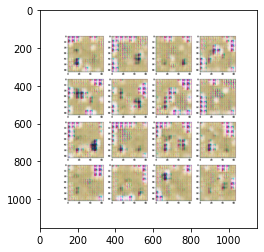

In [21]:
GAN1_epoch_image = cv2.imread("model01/epoch_0004.png")
GAN1_epoch_image = cv2.cvtColor(GAN1_epoch_image, cv2.COLOR_BGR2RGB)
plt.imshow(GAN1_epoch_image)
plt.show()

In [22]:
num_features = 100

generator2 = keras.models.Sequential([
    keras.layers.Dense(4 * 4 * 128, input_shape =[num_features]),
    keras.layers.Reshape([4, 4, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64,(5,5),(2,2),padding="same",activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64,(5,5),(2,2),padding="same",activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64,(5,5),(2,2),padding="same",activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(img_shape[2],(5,5),(2,2),padding="same",activation="tanh")
], name = "generator2")
generator2.summary()

Model: "generator2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 2048)              206848    
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 batch_normalization_2 (Batc  (None, 4, 4, 128)        512       
 hNormalization)                                                 
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 8, 8, 64)         204864    
 ranspose)                                                       
                                                                 
 batch_normalization_3 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                                 
                                                        

In [23]:
discriminator2 = keras.models.Sequential([
    keras.layers.Conv2D(64,(5, 5),(2, 2),padding="same",input_shape=img_shape),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128,(5, 5),(2, 2),padding ="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(256,(5, 5),(2, 2),padding ="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation ='sigmoid')
], name = "discriminator2")
discriminator2.summary()

Model: "discriminator2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       204928    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 256)      

In [24]:
discriminator2.compile(loss = "binary_crossentropy", optimizer = "adam")
discriminator2.trainable = False
GAN2 = keras.models.Sequential([generator2, discriminator2], name = "GAN2")
GAN2.compile(loss = "binary_crossentropy", optimizer = "adam")
GAN2.summary()

Model: "GAN2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator2 (Sequential)     (None, 64, 64, 3)         622723    
                                                                 
 discriminator2 (Sequential)  (None, 1)                1045633   
                                                                 
Total params: 1,668,356
Trainable params: 622,083
Non-trainable params: 1,046,273
_________________________________________________________________


In [25]:
dataset = gen_batch(train_array, batch_size = batch_size, seed_val = 0)
train_DCGAN(GAN2, dataset, batch_size, num_features, epochs = 250, output_path = "model02")

Epoch: 0/250
Epoch: 1/250
Epoch: 2/250
Epoch: 3/250
Epoch: 4/250
Epoch: 5/250
Epoch: 6/250
Epoch: 7/250
Epoch: 8/250
Epoch: 9/250
Epoch: 10/250
Epoch: 11/250
Epoch: 12/250
Epoch: 13/250
Epoch: 14/250
Epoch: 15/250
Epoch: 16/250
Epoch: 17/250
Epoch: 18/250
Epoch: 19/250
Epoch: 20/250
Epoch: 21/250
Epoch: 22/250
Epoch: 23/250
Epoch: 24/250
Epoch: 25/250
Epoch: 26/250
Epoch: 27/250
Epoch: 28/250
Epoch: 29/250
Epoch: 30/250
Epoch: 31/250
Epoch: 32/250
Epoch: 33/250
Epoch: 34/250
Epoch: 35/250
Epoch: 36/250
Epoch: 37/250
Epoch: 38/250
Epoch: 39/250
Epoch: 40/250
Epoch: 41/250
Epoch: 42/250
Epoch: 43/250
Epoch: 44/250
Epoch: 45/250
Epoch: 46/250
Epoch: 47/250
Epoch: 48/250
Epoch: 49/250
Epoch: 50/250
Epoch: 51/250
Epoch: 52/250
Epoch: 53/250
Epoch: 54/250
Epoch: 55/250
Epoch: 56/250
Epoch: 57/250
Epoch: 58/250
Epoch: 59/250
Epoch: 60/250
Epoch: 61/250
Epoch: 62/250
Epoch: 63/250
Epoch: 64/250
Epoch: 65/250
Epoch: 66/250
Epoch: 67/250
Epoch: 68/250
Epoch: 69/250
Epoch: 70/250
Epoch: 71/250
Ep

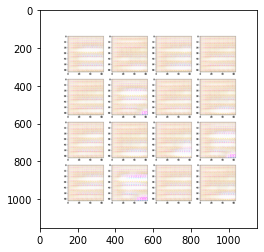

In [26]:
GAN2_epoch_image = cv2.imread("model02/epoch_0249.png")
GAN2_epoch_image = cv2.cvtColor(GAN2_epoch_image, cv2.COLOR_BGR2RGB)
plt.imshow(GAN2_epoch_image)
plt.show()

Well, that was disappointing. Clearly, I'm doing something wrong. Unfortunately, I've spent over 20 hours on this because the training time is so long, so I made some blobs that may or may not get a few points towards being a dog if the Kaggle leaderboard wasn't already closed. I'll debug this in the future (mostly because I want a cat picture generator) but that's going to have to wait until I have more time.